In [1]:
from functools import partial
import torch

from cupbearer import tasks, scripts, utils
from cupbearer.tasks.tiny_natural_mechanisms import get_effect_tokens
from cupbearer.detectors.statistical import MahalanobisDetector
from elk_experiments.auto_circuit_detector import AutoCircuitGradScoresDetector, AutoCircuitPruningDetector
from elk_experiments.tiny_natural_mechanisms_utils import get_task_subset
from elk_experiments.utils import repo_path_to_abs_path
from auto_circuit.types import AblationType
from auto_circuit.data import PromptPairBatch   

In [2]:
def effect_prob_func(logits, effect_tokens, inputs=None):
    assert logits.ndim == 3
    # Sum over vocab and batch dim (for now we're just computing attribution values, we'll deal with per data instance later)
    print(logits.shape)
    probs = logits[:, -1, :].softmax(dim=-1)
    out = probs[:, effect_tokens].mean() # mean over effect tokens, mean over batch
    # out = logits[:, -1, effect_tokens].mean()
    return out

In [3]:
class AutoCircuitGradScoresMahalanobis(AutoCircuitGradScoresDetector, MahalanobisDetector):

    def train(self, **kwargs):
        super().train(**kwargs)
        # Post process
        with torch.inference_mode():
            self.means = self._means
            self.covariances = {k: C / (self._ns[k] - 1) for k, C in self._Cs.items()}
            if any(torch.count_nonzero(C) == 0 for C in self.covariances.values()):
                raise RuntimeError("All zero covariance matrix detected.")

            self.post_covariance_training(**kwargs)

In [4]:
model_name = "pythia-70m"
device="cpu"
task_name="ifelse"

In [5]:
task = get_task_subset(tasks.tiny_natural_mechanisms(task_name, device, model_name), 2048, 1024, 1024)

Loaded pretrained model attn-only-1l into HookedTransformer
Moving model to device:  cpu


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m into HookedTransformer
Moving model to device:  cpu


In [6]:
task.model.tokenizer.add_bos_token

True

In [7]:
effect_tokens = task.model.tokenizer.encode(" else")[1:]
effect_tokens

[2010]

In [8]:
detector_path = repo_path_to_abs_path("output") / f"auto-circuit_mahalanobis_{model_name}_{task_name}_detector"

detector = AutoCircuitGradScoresMahalanobis(
    effect_tokens = effect_tokens, 
    ablation_type=AblationType.ZERO,
    metric=partial(effect_prob_func, effect_tokens=effect_tokens),
    resid_src=False, 
    resid_dest=False,
    mlp_src=False,
    mlp_dest=False,
    device=device, 
)

In [9]:
detector.mlp_dest

False

In [10]:
detector.set_model(task.model)
detector.train(
    trusted_data=task.trusted_data,
    untrusted_data=task.untrusted_train_data,
    save_path=None,
    batch_size=64,
)

2024-07-13 07:10:40.034 | DEBUG    | cupbearer.detectors.statistical.statistical:init_variables:83 - Activation sizes: 
prune_scores: torch.Size([2880])
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([64, 16, 50304])


  3%|▎         | 1/32 [00:01<00:52,  1.69s/it]

torch.Size([64, 16, 50304])


  6%|▋         | 2/32 [00:03<00:48,  1.62s/it]

torch.Size([64, 16, 50304])


  9%|▉         | 3/32 [00:04<00:46,  1.61s/it]

torch.Size([64, 16, 50304])


 12%|█▎        | 4/32 [00:06<00:44,  1.59s/it]

torch.Size([64, 16, 50304])


 16%|█▌        | 5/32 [00:07<00:42,  1.57s/it]

torch.Size([64, 16, 50304])


 19%|█▉        | 6/32 [00:09<00:40,  1.56s/it]

torch.Size([64, 16, 50304])


 22%|██▏       | 7/32 [00:11<00:39,  1.57s/it]

torch.Size([64, 16, 50304])


 25%|██▌       | 8/32 [00:12<00:37,  1.57s/it]

torch.Size([64, 16, 50304])


 28%|██▊       | 9/32 [00:14<00:35,  1.56s/it]

torch.Size([64, 16, 50304])


 31%|███▏      | 10/32 [00:15<00:34,  1.57s/it]

torch.Size([64, 16, 50304])


 34%|███▍      | 11/32 [00:17<00:34,  1.66s/it]

torch.Size([64, 16, 50304])


 38%|███▊      | 12/32 [00:19<00:33,  1.66s/it]

torch.Size([64, 16, 50304])


 41%|████      | 13/32 [00:20<00:31,  1.65s/it]

torch.Size([64, 16, 50304])


 44%|████▍     | 14/32 [00:22<00:29,  1.63s/it]

torch.Size([64, 16, 50304])


 47%|████▋     | 15/32 [00:24<00:27,  1.62s/it]

torch.Size([64, 16, 50304])


 50%|█████     | 16/32 [00:25<00:26,  1.63s/it]

torch.Size([64, 16, 50304])


 53%|█████▎    | 17/32 [00:27<00:24,  1.62s/it]

torch.Size([64, 16, 50304])


 56%|█████▋    | 18/32 [00:28<00:22,  1.61s/it]

torch.Size([64, 16, 50304])


 59%|█████▉    | 19/32 [00:30<00:21,  1.64s/it]

torch.Size([64, 16, 50304])


 62%|██████▎   | 20/32 [00:32<00:19,  1.65s/it]

torch.Size([64, 16, 50304])


 66%|██████▌   | 21/32 [00:33<00:17,  1.63s/it]

torch.Size([64, 16, 50304])


 69%|██████▉   | 22/32 [00:35<00:16,  1.61s/it]

torch.Size([64, 16, 50304])


 72%|███████▏  | 23/32 [00:37<00:14,  1.63s/it]

torch.Size([64, 16, 50304])


 75%|███████▌  | 24/32 [00:38<00:13,  1.63s/it]

torch.Size([64, 16, 50304])


 78%|███████▊  | 25/32 [00:40<00:11,  1.63s/it]

torch.Size([64, 16, 50304])


 81%|████████▏ | 26/32 [00:42<00:09,  1.62s/it]

torch.Size([64, 16, 50304])


 84%|████████▍ | 27/32 [00:43<00:08,  1.62s/it]

torch.Size([64, 16, 50304])


 88%|████████▊ | 28/32 [00:45<00:06,  1.60s/it]

torch.Size([64, 16, 50304])


 91%|█████████ | 29/32 [00:49<00:06,  2.33s/it]

torch.Size([64, 16, 50304])


 94%|█████████▍| 30/32 [00:51<00:04,  2.17s/it]

torch.Size([64, 16, 50304])


 97%|█████████▋| 31/32 [00:52<00:02,  2.01s/it]

torch.Size([64, 16, 50304])


100%|██████████| 32/32 [00:54<00:00,  1.70s/it]


leaving auto_circuit train


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([64, 16, 50304])


Evaluating:   3%|▎         | 1/32 [00:02<01:14,  2.40s/it]

torch.Size([64, 16, 50304])


Evaluating:   6%|▋         | 2/32 [00:04<00:59,  1.97s/it]

torch.Size([64, 16, 50304])


Evaluating:   9%|▉         | 3/32 [00:05<00:51,  1.79s/it]

torch.Size([64, 16, 50304])


Evaluating:  12%|█▎        | 4/32 [00:07<00:47,  1.69s/it]

torch.Size([64, 16, 50304])


Evaluating:  16%|█▌        | 5/32 [00:08<00:44,  1.64s/it]

torch.Size([64, 16, 50304])


Evaluating:  19%|█▉        | 6/32 [00:10<00:42,  1.63s/it]

torch.Size([64, 16, 50304])


Evaluating:  22%|██▏       | 7/32 [00:11<00:39,  1.59s/it]

torch.Size([64, 16, 50304])


Evaluating:  25%|██▌       | 8/32 [00:13<00:37,  1.57s/it]

torch.Size([64, 16, 50304])


Evaluating:  28%|██▊       | 9/32 [00:14<00:35,  1.55s/it]

torch.Size([64, 16, 50304])


Evaluating:  31%|███▏      | 10/32 [00:16<00:33,  1.54s/it]

torch.Size([64, 16, 50304])


Evaluating:  34%|███▍      | 11/32 [00:18<00:32,  1.56s/it]

torch.Size([64, 16, 50304])


Evaluating:  38%|███▊      | 12/32 [00:19<00:31,  1.58s/it]

torch.Size([64, 16, 50304])


Evaluating:  41%|████      | 13/32 [00:21<00:30,  1.59s/it]

torch.Size([64, 16, 50304])


Evaluating:  44%|████▍     | 14/32 [00:22<00:29,  1.64s/it]

torch.Size([64, 16, 50304])


Evaluating:  47%|████▋     | 15/32 [00:24<00:28,  1.65s/it]

torch.Size([64, 16, 50304])


Evaluating:  50%|█████     | 16/32 [00:26<00:26,  1.64s/it]

torch.Size([64, 16, 50304])


Evaluating:  53%|█████▎    | 17/32 [00:27<00:24,  1.63s/it]

torch.Size([64, 16, 50304])


Evaluating:  56%|█████▋    | 18/32 [00:29<00:22,  1.61s/it]

torch.Size([64, 16, 50304])


Evaluating:  59%|█████▉    | 19/32 [00:31<00:20,  1.61s/it]

torch.Size([64, 16, 50304])


Evaluating:  62%|██████▎   | 20/32 [00:32<00:19,  1.60s/it]

torch.Size([64, 16, 50304])


Evaluating:  66%|██████▌   | 21/32 [00:34<00:17,  1.61s/it]

torch.Size([64, 16, 50304])


Evaluating:  69%|██████▉   | 22/32 [00:36<00:16,  1.68s/it]

torch.Size([64, 16, 50304])


Evaluating:  72%|███████▏  | 23/32 [00:37<00:14,  1.66s/it]

torch.Size([64, 16, 50304])


Evaluating:  75%|███████▌  | 24/32 [00:39<00:13,  1.66s/it]

torch.Size([64, 16, 50304])


Evaluating:  78%|███████▊  | 25/32 [00:41<00:11,  1.66s/it]

torch.Size([64, 16, 50304])


Evaluating:  81%|████████▏ | 26/32 [00:42<00:10,  1.72s/it]

torch.Size([64, 16, 50304])


Evaluating:  84%|████████▍ | 27/32 [00:44<00:08,  1.70s/it]

torch.Size([64, 16, 50304])


Evaluating:  88%|████████▊ | 28/32 [00:46<00:06,  1.67s/it]

torch.Size([64, 16, 50304])


Evaluating:  91%|█████████ | 29/32 [00:47<00:04,  1.65s/it]

torch.Size([64, 16, 50304])


Evaluating:  94%|█████████▍| 30/32 [00:49<00:03,  1.64s/it]

torch.Size([64, 16, 50304])


Evaluating:  97%|█████████▋| 31/32 [00:51<00:01,  1.64s/it]

torch.Size([64, 16, 50304])


2024-07-13 07:12:40.352 | INFO     | cupbearer.detectors.anomaly_detector:plot_scores:35 - AUC_ROC (all): 0.6454
2024-07-13 07:12:40.353 | INFO     | cupbearer.detectors.anomaly_detector:plot_scores:36 - AP (all): 0.6019


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.6454429626464844,
               'AP': 0.6019307744235889}}),
 {'all': <Figure size 640x480 with 1 Axes>})

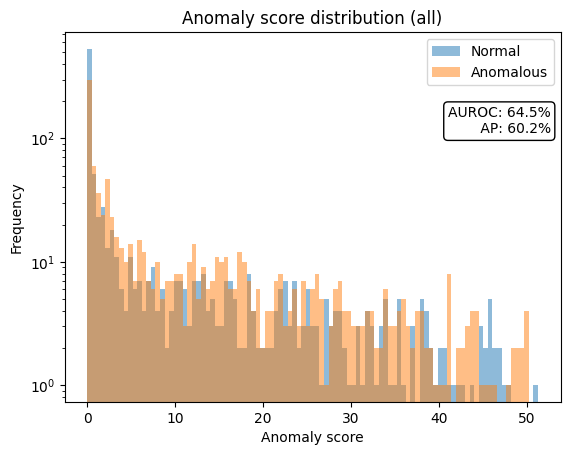

In [11]:
scripts.eval_detector(
    task, 
    detector, 
    save_path=None, 
    pbar=True,
    batch_size=64,
)

TODO:ok, hopefully this is just b/c of the different metric (logit difference between answers and "wrong" answers, should just try sum logits and sum probs)